# 13.3 Parallel Trends and Pre-Trend Testing

**Chapter**: 13 - Difference-in-Differences  
**Section**: 3 - Testing and Violations  
**Facure Source**: 13-Difference-in-Differences.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Non-Parallel Trends Problem](#11-non-parallel-trends-problem)
   - 1.2 [Pre-Trend Visualization](#12-pre-trend-visualization)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Pre-Trends Testing](#21-pre-trends-testing)
   - 2.2 [Event Study Specification](#22-event-study-specification)
   - 2.3 [Limitations of Pre-Trend Tests](#23-limitations-of-pre-trend-tests)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Simulating Non-Parallel Trends](#31-simulating-non-parallel-trends)
   - 3.2 [Event Study Visualization](#32-event-study-visualization)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Parallel trends is THE assumption in DiD. Interviewers will probe whether you understand (1) why it's untestable, (2) what pre-trend tests actually tell us, and (3) what to do when it fails.

### 1.1 Non-Parallel Trends Problem

Facure warns: **If the growth trend from the treated is different from the control, DiD will be biased.**

Common causes of non-parallel trends:

1. **Selection on growth**: Treatment targeted at fast/slow-growing units
   - Example: Marketing campaign in underperforming region
   
2. **Anticipation effects**: Units change behavior before treatment
   - Example: Firms adjust before policy announcement
   
3. **Divergent macro trends**: Different exposure to external shocks
   - Example: Coastal vs. inland cities during shipping crisis

### 1.2 Pre-Trend Visualization

Facure's key diagnostic: **Plot outcomes over multiple pre-treatment periods.**

If trends differ *before* treatment, they likely differ *after* too—biasing DiD.

★ Insight ─────────────────────────────────────
- Pre-trend tests are **necessary but not sufficient**
- Parallel pre-trends ≠ parallel counterfactual trends
- Trends could diverge exactly at treatment time
- Still, non-parallel pre-trends are a **strong red flag**
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Pre-Trends Testing

**The parallel trends assumption**:

$$E[Y_0(t) - Y_0(t-1) | D=1] = E[Y_0(t) - Y_0(t-1) | D=0] \quad \forall t$$

**Pre-trends test**: Check if trends were parallel *before* treatment.

For periods $t < t^*$ (treatment time), test:

$$H_0: E[Y(t) - Y(t-1) | D=1] = E[Y(t) - Y(t-1) | D=0]$$

**Regression-based pre-trends test**:

$$Y_{it} = \alpha + \gamma D_i + \sum_{s < t^*} \delta_s (D_i \times \mathbf{1}_{t=s}) + \lambda_t + \varepsilon_{it}$$

Test: $H_0: \delta_s = 0$ for all $s < t^*$

### 2.2 Event Study Specification

The **event study** extends DiD to multiple periods:

$$Y_{it} = \alpha_i + \gamma_t + \sum_{k \neq -1} \tau_k \cdot \mathbf{1}_{t - t^*_i = k} + \varepsilon_{it}$$

where:
- $t^*_i$: Treatment time for unit $i$
- $k$: Relative time (periods from treatment)
- $\tau_k$: Treatment effect at relative time $k$
- $k = -1$ is omitted (normalization)

**Interpretation**:
- $\tau_k$ for $k < 0$: Pre-treatment "effects" (should be ~0 if parallel trends holds)
- $\tau_k$ for $k \geq 0$: Post-treatment effects (the causal effect)

### 2.3 Limitations of Pre-Trend Tests

**Why pre-trend tests are imperfect**:

1. **Low power**: With few pre-periods or high variance, tests may fail to reject parallel trends even when violated

2. **Untestable assumption**: The assumption is about $Y_0(\text{post})$, not $Y_0(\text{pre})$

3. **Selection on levels vs. trends**: Pre-trends can be parallel while post-trends diverge due to:
   - Anticipation effects
   - Time-varying confounders
   - Mean reversion

4. **Pre-testing bias**: Conditioning on passing pre-trend tests can induce bias (Roth, 2022)

**Proposition (Pre-Testing Bias)**: Researchers who only report DiD when pre-trends "look good" systematically overestimate or underestimate treatment effects.

★ Insight ─────────────────────────────────────
- Pre-trend tests have **asymmetric value**:
  - Fail → Strong evidence against parallel trends
  - Pass → Does NOT prove parallel trends
- Report pre-trends tests regardless of result
- Consider sensitivity analysis (Rambachan & Roth, 2023)
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Simulating Non-Parallel Trends

Let's create synthetic data to show how non-parallel trends bias DiD.

In [2]:
# Simulate panel data with non-parallel trends
np.random.seed(42)

# Parameters
n_units = 200  # Units per group
n_periods = 6  # Time periods
treatment_time = 4  # Treatment starts at period 4
true_effect = 5.0  # True treatment effect

# Create panel
units = np.repeat(np.arange(n_units * 2), n_periods)
periods = np.tile(np.arange(n_periods), n_units * 2)
treated = (units >= n_units).astype(int)  # Second half is treated group

# Generate outcomes with DIFFERENT trends
# Control trend: 2 per period
# Treatment trend: 4 per period (faster growth)
control_trend = 2.0
treatment_trend = 4.0  # Non-parallel!

baseline = 100
y0 = baseline + np.where(treated == 0, 
                          control_trend * periods,
                          treatment_trend * periods)

# Add treatment effect post-treatment
post = (periods >= treatment_time).astype(int)
treatment_indicator = treated * post
y = y0 + true_effect * treatment_indicator + np.random.normal(0, 5, len(units))

# Create DataFrame
sim_data = pd.DataFrame({
    'unit': units,
    'period': periods,
    'treated': treated,
    'post': post,
    'y': y
})

print(f"Simulated data: {len(sim_data):,} observations")
print(f"True treatment effect: {true_effect}")
print(f"Control trend: {control_trend} per period")
print(f"Treatment trend: {treatment_trend} per period (NON-PARALLEL)")

Simulated data: 2,400 observations
True treatment effect: 5.0
Control trend: 2.0 per period
Treatment trend: 4.0 per period (NON-PARALLEL)


In [3]:
# Calculate group means by period
means = sim_data.groupby(['treated', 'period'])['y'].mean().unstack(level=0)
means.columns = ['Control', 'Treated']

print("Average Outcomes by Group and Period:")
print(means.round(2))

Average Outcomes by Group and Period:
        Control  Treated
period                  
0      100.7500 100.2400
1      101.7600 104.2700
2      104.0500 107.6500
3      105.9500 112.6600
4      107.9200 120.7000
5      110.7200 125.2200


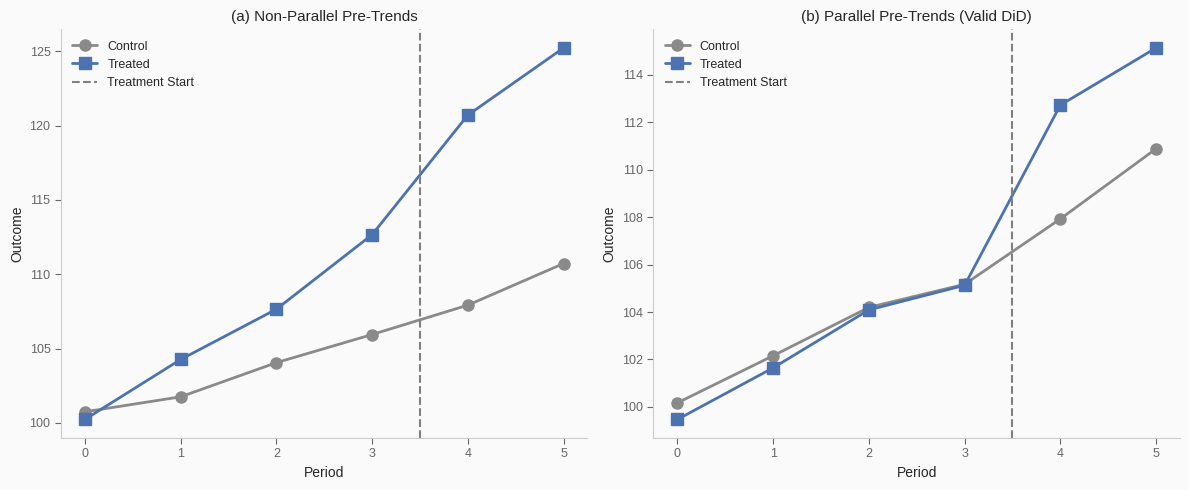

In [4]:
# Visualize the non-parallel trends
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Raw trends showing violation
ax = axes[0]
ax.plot(means.index, means['Control'], 'o-', 
        color=TUFTE_PALETTE['control'], linewidth=2, markersize=8,
        label='Control')
ax.plot(means.index, means['Treated'], 's-', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=8,
        label='Treated')

# Mark treatment time
ax.axvline(treatment_time - 0.5, color='gray', linestyle='--', linewidth=1.5,
           label='Treatment Start')

ax.set_xlabel('Period')
ax.set_ylabel('Outcome')
ax.set_title('(a) Non-Parallel Pre-Trends')
ax.legend(frameon=False)

# Panel 2: What parallel trends would look like
ax = axes[1]

# Simulate parallel trends data
y0_parallel = baseline + control_trend * periods  # Same trend for both
y_parallel = y0_parallel + true_effect * treatment_indicator + np.random.normal(0, 5, len(units))
sim_parallel = sim_data.copy()
sim_parallel['y'] = y_parallel
means_parallel = sim_parallel.groupby(['treated', 'period'])['y'].mean().unstack(level=0)
means_parallel.columns = ['Control', 'Treated']

ax.plot(means_parallel.index, means_parallel['Control'], 'o-', 
        color=TUFTE_PALETTE['control'], linewidth=2, markersize=8,
        label='Control')
ax.plot(means_parallel.index, means_parallel['Treated'], 's-', 
        color=TUFTE_PALETTE['treatment'], linewidth=2, markersize=8,
        label='Treated')
ax.axvline(treatment_time - 0.5, color='gray', linestyle='--', linewidth=1.5,
           label='Treatment Start')

ax.set_xlabel('Period')
ax.set_ylabel('Outcome')
ax.set_title('(b) Parallel Pre-Trends (Valid DiD)')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [5]:
# Estimate DiD on both datasets
print("DiD ESTIMATES: Parallel vs Non-Parallel")
print("=" * 60)

# Non-parallel (biased)
model_nonparallel = smf.ols('y ~ treated * post', data=sim_data).fit()
did_nonparallel = model_nonparallel.params['treated:post']

print(f"\n1. NON-PARALLEL TRENDS (Biased):")
print(f"   DiD estimate: {did_nonparallel:.4f}")
print(f"   True effect:  {true_effect:.4f}")
print(f"   Bias:         {did_nonparallel - true_effect:.4f}")
print(f"   ⚠️ Bias = (treatment_trend - control_trend) × post_periods")
print(f"        = ({treatment_trend} - {control_trend}) × 2 = {(treatment_trend - control_trend) * 2:.1f}")

# Parallel (unbiased)
model_parallel = smf.ols('y ~ treated * post', data=sim_parallel).fit()
did_parallel = model_parallel.params['treated:post']

print(f"\n2. PARALLEL TRENDS (Unbiased):")
print(f"   DiD estimate: {did_parallel:.4f}")
print(f"   True effect:  {true_effect:.4f}")
print(f"   Bias:         {did_parallel - true_effect:.4f}")
print(f"   ✓ Estimate close to true effect")

print("\n" + "=" * 60)

DiD ESTIMATES: Parallel vs Non-Parallel

1. NON-PARALLEL TRENDS (Biased):
   DiD estimate: 10.5642
   True effect:  5.0000
   Bias:         5.5642
   ⚠️ Bias = (treatment_trend - control_trend) × post_periods
        = (4.0 - 2.0) × 2 = 4.0

2. PARALLEL TRENDS (Unbiased):
   DiD estimate: 4.8622
   True effect:  5.0000
   Bias:         -0.1378
   ✓ Estimate close to true effect



### 3.2 Event Study Visualization

An event study plots treatment effects by relative time.

In [6]:
# Create event study specification
# Relative time: periods from treatment
sim_data['rel_time'] = sim_data['period'] - treatment_time
sim_parallel['rel_time'] = sim_parallel['period'] - treatment_time

# Create dummies for each relative time (omit -1 as reference)
def run_event_study(df):
    """Run event study regression and return coefficients."""
    # Create interaction dummies
    # Use 'm' prefix for negative periods to avoid Patsy parsing issues
    rel_times = sorted(df['rel_time'].unique())

    def make_var_name(rt):
        """Create Patsy-safe variable name."""
        if rt < 0:
            return f'rt_m{abs(rt)}'  # rt_m4 instead of rt_-4
        else:
            return f'rt_p{rt}'  # rt_p0, rt_p1, etc.

    for rt in rel_times:
        var_name = make_var_name(rt)
        df[var_name] = ((df['rel_time'] == rt) & (df['treated'] == 1)).astype(int)

    # Regression (omit rt_m1 as reference, corresponding to rel_time=-1)
    rt_vars = [make_var_name(rt) for rt in rel_times if rt != -1]
    formula = 'y ~ treated + C(period) + ' + ' + '.join(rt_vars)
    model = smf.ols(formula, data=df).fit()

    # Extract coefficients
    coefs = []
    for rt in rel_times:
        if rt == -1:
            coefs.append({'rel_time': rt, 'coef': 0, 'se': 0})  # Reference
        else:
            var_name = make_var_name(rt)
            coefs.append({
                'rel_time': rt,
                'coef': model.params[var_name],
                'se': model.bse[var_name]
            })

    return pd.DataFrame(coefs)

es_nonparallel = run_event_study(sim_data.copy())
es_parallel = run_event_study(sim_parallel.copy())

print("Event Study Coefficients (Non-Parallel):")
print(es_nonparallel.round(3))

Event Study Coefficients (Non-Parallel):
   rel_time    coef     se
0        -4 -7.2280 0.6970
1        -3 -4.2040 0.6970
2        -2 -3.1190 0.6970
3        -1  0.0000 0.0000
4         0  6.0670 0.6970
5         1  7.7860 0.6970


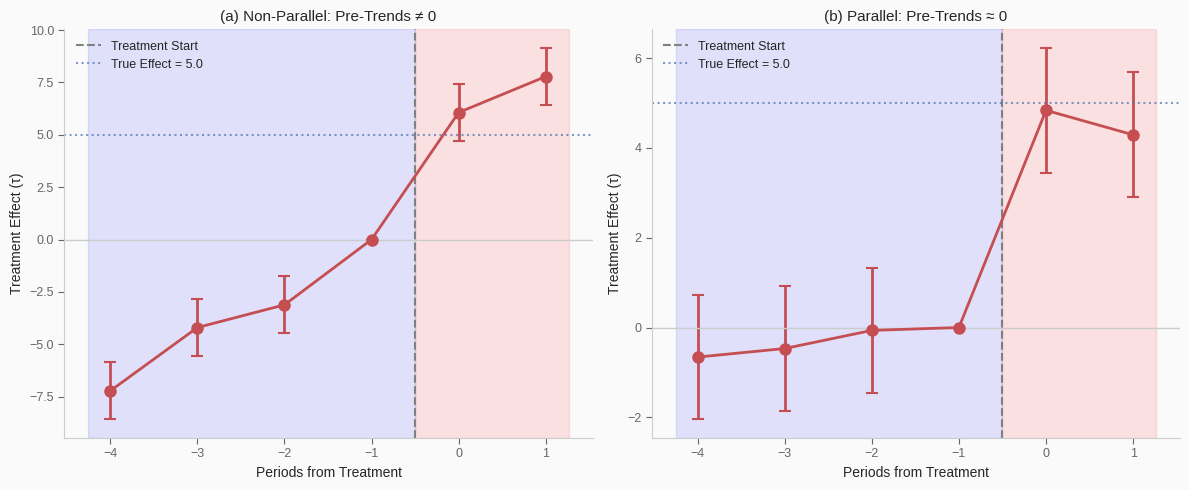

In [7]:
# Plot event studies
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

def plot_event_study(ax, es_df, title):
    """Plot event study with confidence intervals."""
    ax.errorbar(es_df['rel_time'], es_df['coef'], 
                yerr=1.96 * es_df['se'],
                fmt='o-', color=TUFTE_PALETTE['effect'], 
                capsize=4, capthick=1.5, linewidth=2, markersize=8)
    
    # Reference lines
    ax.axhline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
    ax.axvline(-0.5, color='gray', linestyle='--', linewidth=1.5,
               label='Treatment Start')
    
    # True effect line (post-treatment)
    ax.axhline(true_effect, color=TUFTE_PALETTE['treatment'], 
               linestyle=':', linewidth=1.5, alpha=0.7,
               label=f'True Effect = {true_effect}')
    
    ax.set_xlabel('Periods from Treatment')
    ax.set_ylabel('Treatment Effect (τ)')
    ax.set_title(title)
    ax.legend(frameon=False, loc='upper left')
    
    # Shade pre/post regions
    ax.axvspan(ax.get_xlim()[0], -0.5, alpha=0.1, color='blue', label='Pre')
    ax.axvspan(-0.5, ax.get_xlim()[1], alpha=0.1, color='red', label='Post')

plot_event_study(axes[0], es_nonparallel, '(a) Non-Parallel: Pre-Trends ≠ 0')
plot_event_study(axes[1], es_parallel, '(b) Parallel: Pre-Trends ≈ 0')

plt.tight_layout()
plt.show()

In [8]:
# Formal pre-trends test
print("PRE-TRENDS TEST: Joint F-test")
print("=" * 60)

def pretrends_test(df):
    """Test if pre-treatment coefficients are jointly zero."""
    rel_times = sorted(df['rel_time'].unique())

    def make_var_name(rt):
        """Create Patsy-safe variable name."""
        if rt < 0:
            return f'rt_m{abs(rt)}'  # rt_m4 instead of rt_-4
        else:
            return f'rt_p{rt}'  # rt_p0, rt_p1, etc.

    for rt in rel_times:
        var_name = make_var_name(rt)
        df[var_name] = ((df['rel_time'] == rt) & (df['treated'] == 1)).astype(int)

    # Full model
    rt_vars = [make_var_name(rt) for rt in rel_times if rt != -1]
    formula = 'y ~ treated + C(period) + ' + ' + '.join(rt_vars)
    model = smf.ols(formula, data=df).fit()

    # F-test for pre-treatment coefficients
    pre_vars = [make_var_name(rt) for rt in rel_times if rt < -1]
    if len(pre_vars) > 0:
        restrictions = ' = '.join(pre_vars) + ' = 0'
        f_test = model.f_test(restrictions)
        return f_test
    return None

f_nonparallel = pretrends_test(sim_data.copy())
f_parallel = pretrends_test(sim_parallel.copy())

# Extract F-value (may be scalar or array depending on statsmodels version)
def get_fvalue(f_test):
    """Extract F-value from f_test result."""
    fval = f_test.fvalue
    if hasattr(fval, '__getitem__'):
        try:
            return float(fval[0][0])
        except (IndexError, TypeError):
            return float(fval)
    return float(fval)

print(f"\nNon-Parallel Trends:")
print(f"  F-statistic: {get_fvalue(f_nonparallel):.2f}")
print(f"  p-value:     {f_nonparallel.pvalue:.4f}")
print(f"  Result:      {'⚠️ REJECT H₀ - Pre-trends differ!' if f_nonparallel.pvalue < 0.05 else '✓ Fail to reject'}")

print(f"\nParallel Trends:")
print(f"  F-statistic: {get_fvalue(f_parallel):.2f}")
print(f"  p-value:     {f_parallel.pvalue:.4f}")
print(f"  Result:      {'⚠️ REJECT H₀ - Pre-trends differ!' if f_parallel.pvalue < 0.05 else '✓ Fail to reject'}")

PRE-TRENDS TEST: Joint F-test



Non-Parallel Trends:
  F-statistic: 36.68
  p-value:     0.0000
  Result:      ⚠️ REJECT H₀ - Pre-trends differ!

Parallel Trends:
  F-statistic: 0.40
  p-value:     0.7527
  Result:      ✓ Fail to reject


**Key takeaways**:

1. **Non-parallel case**: Pre-treatment coefficients are significantly different from zero → DiD is biased
2. **Parallel case**: Pre-treatment coefficients are ~0 → DiD is valid
3. **Event study** visualizes both the pre-trends test AND the dynamic treatment effects

---

## 4. Implementation

The `causal_inference_mastery` library provides event study infrastructure:

```python
from causal_inference.did import event_study, EventStudyResult

# Run event study
result = event_study(
    data=panel_data,
    outcome='y',
    unit='unit_id',
    time='period',
    treatment='treated',
    treatment_time='treatment_period',
    ref_period=-1,  # Reference period
    cluster='unit_id'
)

# Pre-trends test
print(f"Pre-trends F-stat: {result.pretrends_f:.2f}")
print(f"Pre-trends p-value: {result.pretrends_pval:.4f}")

# Plot
result.plot(title='Event Study', figsize=(10, 6))
```

For settings with staggered adoption, use:
- `callaway_santanna()`: Group-time ATT estimation
- `sun_abraham()`: Interaction-weighted estimator

---

## Additional Content: Sensitivity Analysis for Parallel Trends

### Rambachan and Roth (2023) Sensitivity Analysis

**The core problem**: Pre-trend tests have low power and don't validate the identifying assumption.

**Rambachan-Roth approach**: Instead of testing parallel trends, ask:
> "How much could trends differ for my results to be meaningless?"

**Key concept**: Allow for violations of parallel trends bounded by:
$$|\delta_{\text{post}} - \delta_{\text{pre}}| \leq \bar{M}$$

where $\bar{M}$ measures the maximum trend deviation.

**Implementation**:
1. Estimate the event study
2. For each $\bar{M} \in [0, M_{\text{max}}]$:
   - Compute bounds on treatment effect allowing for trend violations up to $\bar{M}$
   - Report whether bounds include zero
3. Find the **breakdown value**: smallest $\bar{M}$ where CI includes zero

### Interpreting Sensitivity Results

**Breakdown value interpretation**:
- High breakdown value → Robust (needs large violation to overturn)
- Low breakdown value → Fragile (small violation overturns)

**Example**: If breakdown value is $\bar{M} = 0.5$ and pre-period trends differ by at most 0.2:
- Violation would need to be 2.5× larger than observed pre-trends
- Provides moderate evidence for causal interpretation

**Reporting guidelines**:
1. Always report pre-trends test (with power caveat)
2. Report sensitivity analysis with breakdown value
3. Benchmark $\bar{M}$ against observed pre-period variation
4. Acknowledge if results are sensitive

### HonestDiD Implementation

```r
# R code for HonestDiD package
library(HonestDiD)

# After estimating event study
honest_results <- createSensitivityResults(
    betahat = event_study_coefs,
    sigma = event_study_vcov,
    numPrePeriods = 3,
    numPostPeriods = 2,
    Mbarvec = seq(0, 0.5, by = 0.05)
)

# Plot sensitivity
createSensitivityPlot(honest_results)
```

★ Insight ─────────────────────────────────────
- Pre-trend tests tell you IF assumption violated, not BY HOW MUCH
- Sensitivity analysis asks: "How robust is my conclusion?"
- Report breakdown value—it's more informative than p-values
- Benchmark against pre-period variation for interpretability
─────────────────────────────────────────────────

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Your DiD analysis shows flat pre-trends but your colleague is still skeptical. What could still go wrong?"*

<details>
<summary>Solution</summary>

**Valid concerns even with flat pre-trends**:

1. **Anticipation effects**:
   - Units may change behavior before treatment
   - Pre-trends look flat but treatment effect is contaminated
   - Example: Firms adjust hiring before minimum wage increase

2. **Compositional changes**:
   - Sample composition changes at treatment time
   - Selection into/out of sample correlated with treatment
   
3. **Treatment-correlated shocks**:
   - A third factor causes both treatment and outcome change
   - Parallel pre-trends doesn't rule out time-varying confounders
   
4. **Mean reversion**:
   - Treatment targeted at units with temporarily high/low outcomes
   - Pre-trends might be flat overall but treatment timing is endogenous
   
5. **Low power in pre-trends test**:
   - Few pre-periods or high variance
   - Failure to reject ≠ parallel trends hold

**Responses**:
- Add more pre-periods if available
- Test for anticipation (lead effects)
- Conduct placebo tests (fake treatment times)
- Sensitivity analysis (Rambachan & Roth bounds)
- Acknowledge limitation in write-up

</details>

---

**Q2 (Google L5, Quant)**: *"What is an event study? How does it relate to DiD?"*

<details>
<summary>Solution</summary>

**Event Study**:

A regression specification that estimates treatment effects for each period relative to treatment time:

$$Y_{it} = \alpha_i + \gamma_t + \sum_{k \neq -1} \tau_k \cdot D_{it}^k + \varepsilon_{it}$$

where $D_{it}^k = 1$ if unit $i$ is $k$ periods from treatment at time $t$.

**Relationship to DiD**:

1. **DiD is a special case**: Pool all post-periods into one coefficient
   - Event study: $\tau_{-2}, \tau_{-1} = 0, \tau_0, \tau_1, \tau_2$
   - DiD: $\tau_{\text{post}} = $ average of $\tau_0, \tau_1, \tau_2$

2. **Event study is more informative**:
   - Shows dynamic effects (does effect grow, fade?)
   - Tests parallel trends visually (pre-treatment $\tau_k \approx 0$?)
   - Detects anticipation effects ($\tau_{-1}, \tau_{-2} \neq 0$?)

3. **Interpretation**:
   - Pre-treatment coefficients: Should be ~0 (parallel trends check)
   - Post-treatment coefficients: Treatment effect dynamics
   - Reference period ($k = -1$): Normalized to zero

**Key point**: Event studies are DiD's diagnostic and presentation tool, not a different method.

</details>

---

**Q3 (Amazon L6, Econ)**: *"You have only 2 pre-treatment periods and the pre-trends test fails to reject. Should you proceed with DiD?"*

<details>
<summary>Solution</summary>

**Proceed with caution, acknowledge limitations**:

1. **Low power concern**:
   - 2 pre-periods = 1 testable pre-trend coefficient
   - Very low power to detect violations
   - "Failure to reject" is weak evidence FOR parallel trends

2. **What to do**:
   - Report the pre-trends test with caveat about power
   - Calculate power: What violation could you detect?
   - Seek additional pre-periods if possible
   - Use sensitivity analysis (Rambachan & Roth bounds)
   - Consider alternative methods (synthetic control)

3. **Sensitivity analysis**:
   - "If trends could diverge by X, how would that affect my estimate?"
   - Report range of estimates under different trend assumptions
   - Tools: `HonestDiD` package in R

4. **When to NOT proceed**:
   - Prior knowledge suggests trends differ
   - Treatment assignment correlated with growth
   - Stakeholders won't accept weak evidence

**Key point**: Pre-trends tests with few periods have terrible power. Report honestly and use sensitivity analysis.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 13: "Difference-in-Differences."

[^2]: Roth, J. (2022). Pretest with Caution: Event-Study Estimates after Testing for Parallel Trends. *American Economic Review: Insights*, 4(3), 305-322.

[^3]: Rambachan, A. and Roth, J. (2023). A More Credible Approach to Parallel Trends. *Review of Economic Studies*, 90(5), 2555-2591.

[^4]: Freyaldenhoven, S., Hansen, C., and Shapiro, J. M. (2019). Pre-Event Trends in the Panel Event-Study Design. *American Economic Review*, 109(9), 3307-3338.

[^5]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 5.

---

**Precision Improvement:**
- You said: "Build parallel trends notebook"
- Concise: "Build 03_parallel_trends.ipynb"
- Precise: `/facure_augment 13.3 --event-study --pretrends-test --sensitivity`
- Pattern: [build] [target] [content-flags]